# Part 1

Generate spikes for 10 s (or longer if you want better statistics) using a Poisson spike generator with a constant rate of 100 Hz, and record their times of occurrence. Compute the coefficient of variation of the interspike intervals, and the Fano factor for spike counts obtained over counting intervals ranging from 1 ms to 100 ms. Plot the interspike interval histogram.

The coefficient of variation of the inter-spike intervals is 0.973.
The Fano factors of the spike counts when the bin size is 1 ms is 0.906 and 0.958 for when it is 100 ms.


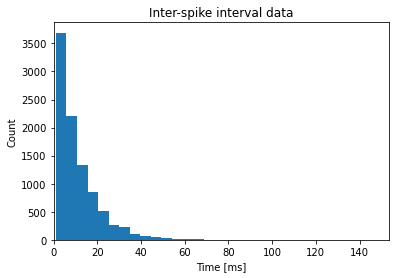

In [25]:
# Import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal 

# For replicability
np.random.seed(101)

# Exercise 1_1
# Our goal is to generate and analyse spike times using a Poisson spike generator with a
# constant rate of 100 Hz. In other words, a homogeneous Poisson point process. We
# additionally need to obtain the inter-spike interval distribution and then calculate the
# Fano factor and the coefficient of variation

T = 100  # total time, seconds
r = 100  # firing rate, Hz
time_step = 0.001  # seconds
time_vector_max = int(T/time_step)
time_vector = np.arange(0, time_vector_max)
rt = time_step*r

# Generate the spikes using the native Poisson pdf function
spikes = np.random.poisson(lam=rt, size=time_vector_max)
spikes[spikes > 1] = 1

# Make a copy for later
spikes_org = spikes

# Obtain the spike times
spike_times = time_vector[spikes == 1]

# Generate the inter-spike interval data
t_isi = np.diff(spike_times)

# Plot the inter-spike interval data
plt.hist(t_isi, bins=30)
plt.xlim(left=0)
plt.title("Inter-spike interval data")
plt.xlabel("Time [ms]")
plt.ylabel("Count")

mean_t_isi = np.mean(t_isi)
std_t_isi = np.std(t_isi)
var_t_isi = std_t_isi**2
C_v = std_t_isi/mean_t_isi

# Calculate the Fano for 1 ms window
Fano_1ms = (np.std(spikes)**2)/np.mean(spikes)

k = 100

counts = []
for i in range(1, int(len(spikes)/k+1)):
    counts.append(sum(spikes[(i-1)*k:(i*k)]))

# Calculate the Fano for 100 ms window
Fano_100ms = np.var(counts)/np.mean(counts)


print(f"The coefficient of variation of the inter-spike intervals is {C_v:.3f}.")
print(f"The Fano factors of the spike counts when the bin size is 1 ms is {Fano_1ms:.3f} and "
      f"{Fano_100ms:.3f} for when it is 100 ms.")
plt.show()

# Part 2

Add a refractory period to the Poisson spike generator by allowing the firing rate to depend on time. Initially, set the firing rate to a constant value, $r(t)=r_0$. After every spike, set $r(t)$ to 0, and then allow it to recover exponentially back to $r_0$ with a time constant $\tau_{ref}$ that controls the refractory recovery rate. In other words, have $r(t)$ obey the equation

$$ 
\tau_{ref} \frac{dr}{dt} = r_0 - r 
$$

except immediately after a spike, when it is set to 0. Plot the coefficient of variation as a function of $\tau_{ref}$ over the range 1 ms $\leq \tau_{ref} \leq$ 20 ms, and plot interspike interval histograms for a few different values of $\tau_{ref}$ in this range. Compute the Fano factor for spike counts obtained
over counting intervals ranging from 1 to 100 ms for the case $\tau_{ref}$ = 10 ms. 

In [252]:
# For replicability
np.random.seed(101)

# Exercise 1_2
# Here, our task is to add a refractory period to the Poisson spike generator we created above. This 
# essentially turns the homogeneous Poisson point process into inhomogeneous since the rate is time-dependent. 
# In order to do that, we need to solve the differential equation given above. The section below explains how.

The solution to the differential equation in the continuous case is actually given in the book, see Mathematical Appendix A.3 Differential Equations, equation A.68. However, we need to discretise the solution for our present purposes. 

$$ 
\tau_{ref} \frac{dr}{dt} = r_0 - r(t)
$$

We need to integrate over the interval $[t, t + \Delta t ] $. Firstly, we use a placeholder variable $z(t)$ and set it to $z(t) = r(t) - r_0$ and we rewrite the equation as follows

$$
\frac{dz}{z} = -\frac{dt}{\tau_{ref}}
$$

Then we integrate both sides. 
LHS:

$$
\int_{z(t)}^{z(t+\Delta t)} dz' \frac{1}{z'} = ln(z(t + \Delta t)) - ln(z(t)) = ln \left( \frac{z(t + \Delta t)}{z(t)} \right)
$$

and RHS: 

$$
\int_{z(t)}^{z(t+\Delta t)} -\frac{dt}{\tau_{ref}} = -\frac{\Delta t}{\tau_{ref}}
$$

which yields, after taking the exponential of both sides
$$
\frac{z(t + \Delta t)}{z(t)} = exp \left ( -\frac{\Delta t}{\tau_{ref}} \right)
$$

$$
z(t + \Delta t) = z(t) \cdot exp \left ( -\frac{\Delta t}{\tau_{ref}} \right)
$$

Substituting back the $z$

$$
r(t + \Delta t) - r_0 = (r(t) - r_0 ) \cdot exp \left ( -\frac{\Delta t}{\tau_{ref}} \right)
$$

Thus, the solution is:

$$
r(t + \Delta t) = r_0 + (r(t) - r_0) \cdot exp \left ( -\frac{\Delta t}{\tau_{ref}} \right)
$$

(NB: Technically, we are making the assumption here that the $\Delta t$ is small enough that the firing rate doesn't change in this window.) 

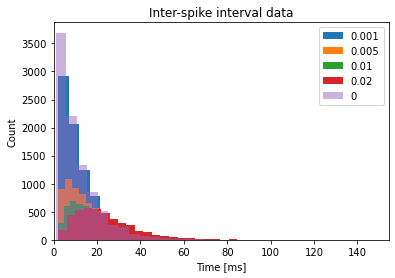

In [253]:
T = 100  # total time, seconds
r_0 = 100  # firing rate, Hz
time_step = 0.001  # seconds
time_vector_max = int(T/time_step)
time_vector = np.arange(0, time_vector_max)

# Generate the spikes using the native Poisson pdf function in a for loop this time 

def spike_generation(tau_r, spike_data):

    r = []
    spikes = []
    for count, value in enumerate(time_vector):

        # Set firing rate to the steady state value at first 
        if count == 0:
            r.append(r_0) 
            spikes.append(int(np.random.poisson(lam=r[count]*time_step, size=1)))

        else:  
            
            # Set firing rate to 0 immediately after a spike 
            if spikes[count-1] != 0: 
                r.append(0) 
                spikes.append(int(np.random.poisson(lam=r[count]*time_step, size=1)))
                
            else: 
                r.append(r_0 + (r[count-1] - r_0)*np.exp(-time_step/tau_r))
                spikes.append(int(np.random.poisson(lam=r[count]*time_step, size=1)))

    spikes = np.array(spikes)
    spikes[spikes > 1] = 1
    return spikes


# Create a list of taus 
tau_list = [0.001, 0.005, 0.01, 0.02]
spike_data = {}
isi_data = {}
Fano_1ms = []
Fano_100ms = []
C_v = []
k = 100

for tau_r in tau_list:

    spikes = spike_generation(tau_r, spike_data)
    spike_data[f"{tau_r}"] = spikes
    spike_times = time_vector[spike_data[f"{tau_r}"] == 1]
    isi_data[f"{tau_r}"] = np.diff(time_vector[spike_data[f"{tau_r}"] == 1])
    plt.hist(isi_data[f"{tau_r}"], bins=30)

    # Calculate the Fano for 1 ms window
    Fano_1ms.append((np.std(spikes)**2)/np.mean(spikes))

    # Compute the Fano factor for 100 ms window 
    counts = []
    for i in range(1, int(len(spikes)/k+1)):
        counts.append(sum(spikes[(i-1)*k:(i*k)]))

    Fano_100ms.append(np.var(counts)/np.mean(counts)) 
    
    # Compute the Cv for each isi 
    mean_t_isi = np.mean(isi_data[f"{tau_r}"])
    std_t_isi = np.std(isi_data[f"{tau_r}"])
    var_t_isi = std_t_isi**2
    C_v.append(std_t_isi/mean_t_isi)

    
# Plot the inter-spike interval data
# plt.figure()
plt.hist(t_isi, bins=30, alpha=0.5)
plt.xlim(left=0)
plt.title("Inter-spike interval data")
plt.xlabel("Time [ms]")
plt.ylabel("Count")
legend = []
[legend.append(val) for val in tau_list]
legend.append(0)
plt.legend(legend)
plt.show()    

# NB: The legend shows the values of tau for which the respective histogram was obtained. We also included the 
# histogram from the previous part for contrast

In [254]:
# Put together a simple table of our values 
df = pd.DataFrame()
df["Tau"] = tau_list
df["Cv"] = C_v
df["Fano 1ms"] = Fano_1ms
df["Fano 100ms"] = Fano_100ms
df

,Tau,Cv,Fano 1ms,Fano 100ms
0,0.001,0.855792,0.91795,0.726749
1,0.005,0.704885,0.93493,0.480091
2,0.010,0.648064,0.94541,0.469742
3,0.020,0.606202,0.95712,0.412093


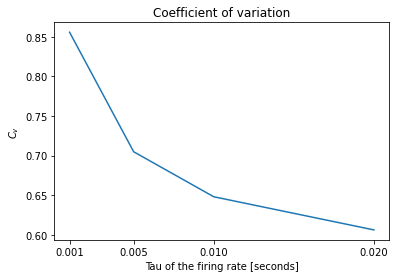

In [255]:
plt.figure()
plt.plot(tau_list, C_v)
plt.title("Coefficient of variation")
plt.xlabel("Tau of the firing rate [seconds]")
plt.ylabel("$C_v$")
plt.xticks(tau_list)
plt.show()

# Part 3

Compute autocorrelation histograms of spike trains generated by a Poisson generator with a constant firing rate of 100 Hz, a constant firing rate of 100 Hz together with a refractory period modeled as in exercise 2 with $\tau_{ref}$ = 10 ms, and a variable firing rate $r(t)$ = 100(1 + cos(2 $\pi t$/25 ms)) Hz. Plot the histograms over a range from 0 to 100 ms.

In [256]:
# We consider 3 cases: 
# 1. 100 Hz firing rate Poisson without a refractory period 
# 2. 100 Hz firing rate Poisson with a refractory period with tau of 10 ms
# 3. Harmonically varyng firing rate Poisson with a maximum of 100 Hz 

# 1. 100 Hz, no refractory period 
autocor_1 = np.correlate(spikes_org, spikes_org, mode='full')/len(spikes_org)

# 2. 100 Hz, ref tau 0.01
autocor_2 = np.correlate(spike_data["0.01"], spike_data["0.01"], mode='full')/len(spike_data["0.01"])

# 3. Variable firing rate 
harmonic_spikes = []
for t in time_vector:
    r = 100*(1+np.cos(2*np.pi*(t/1000)/0.025))
    harmonic_spikes.append(int(np.random.poisson(lam=r*time_step, size=1)))
harmonic_spikes = np.array(harmonic_spikes)
harmonic_spikes[harmonic_spikes > 1] = 1
autocor_3 = np.correlate(harmonic_spikes, harmonic_spikes, mode='full')/len(harmonic_spikes)

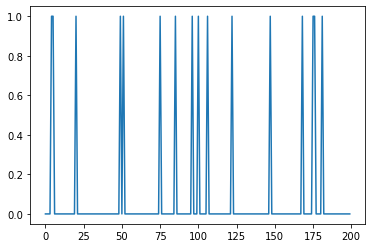

In [257]:
# Just to check that we coded everything correctly, the harmonic spikes should oscillate with high firing 
# rate values every 25ms. Ths is indeed what we see empirically when we plot the spikes
plt.plot(harmonic_spikes[0:200])

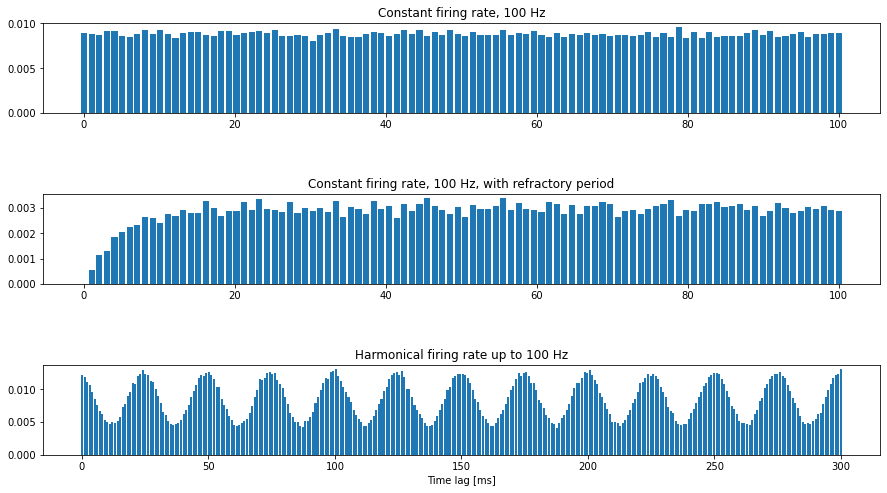

In [258]:
fig, axs = plt.subplots(3, figsize=(15,4))

# extract the autocorrelation values for positive lags
AotuCorr3 = autocor_3[int(np.ceil(autocor_3.size/2)):][0:300]
AotuCorr2 = autocor_2[int(np.ceil(autocor_2.size/2)):][0:100]
AotuCorr1 = autocor_1[int(np.ceil(autocor_1.size/2)):][0:100]
x = np.linspace(0, len(AotuCorr1), len(AotuCorr1))
x2 = np.linspace(0, len(AotuCorr3), len(AotuCorr3))

# Plot all three figures together 
axs[0].bar(x, AotuCorr1)
axs[0].set_title("Constant firing rate, 100 Hz")
axs[1].bar(x, AotuCorr2)
axs[1].set_title("Constant firing rate, 100 Hz, with refractory period")
axs[2].bar(x2, AotuCorr3)
axs[2].set_title("Harmonical firing rate up to 100 Hz")
axs[2].set_xlabel("Time lag [ms]")

plt.subplots_adjust(bottom=0.1,
                    top=1.6,
                    wspace=0.4,
                    hspace=0.9)

# Part 4

Generate a Poisson spike train with a time-dependent firing rate $r(t)=100(1+cos(2 \pi t $ / 300 ms)) Hz. Approximate the firing rate from this spike train using a variable $r_{approx}$ that satisfies

$$
\tau_{approx} \frac{d r_{approx}}{dt} = -r_{approx}
$$

except that $r_{approx} \longrightarrow r_{approx} + 1 /\tau_{approx} $ every time a spike occurs. Make plots of the true rate, the spike sequence generated, and the estimated rate. Experiment with a few different values of $\tau_{approx}$ the range of 1 to 100 ms. Determine the best value of $\tau_{approx}$ by computing the average squared error of the estimate, $\int dt (r(t) - r_{approx}(t))^2$, for different values of $\tau_{approx}$, and finding the value of $\tau_{approx}$ that minimizes this error.

Firstly, we need to solve the differential equation. We can do so as follows (ignoring any constants). 

$$
- \tau_{approx} \frac{d r_{approx}}{r_{approx}} = dt
$$

Integrating both parts

$$
r_{approx}(t+\Delta t)  = r_{approx}(t) \cdot e^{(-\frac{dt}{\tau_{approx}})}
$$

In [259]:
# Approximate firing rate 
tau_approx_list = [0.01, 0.02, 0.05, 0.1]
    
# Poisson generated firing rate 
harmonic_spikes_2 = []
r_list = []

r_approx = pd.DataFrame({
    '0.01': [],
    '0.02': [],
    '0.05': [],
    '0.1': []
})

for count, t in enumerate(time_vector[0:5000]):
    r = 100*(1+np.cos(2*np.pi*(t/1000)/0.3))
    r_list.append(r)
    harmonic_spikes_2.append(int(np.random.poisson(lam=r*time_step, size=1)))

    # Loop through a list of taus 
    for tau_approx in tau_approx_list:
        
        if count == 0:
            r_approx.loc[count, str(tau_approx)] = r
        
        else:
            r_approx.loc[count, str(tau_approx)] = np.exp(-time_step/tau_approx)*r_approx.loc[count-1, str(tau_approx)]
    
        # If a spike was generated  
        if harmonic_spikes_2[-1] > 0: 
            r_approx.loc[count, str(tau_approx)] = r_approx.loc[count, str(tau_approx)] + 1/tau_approx


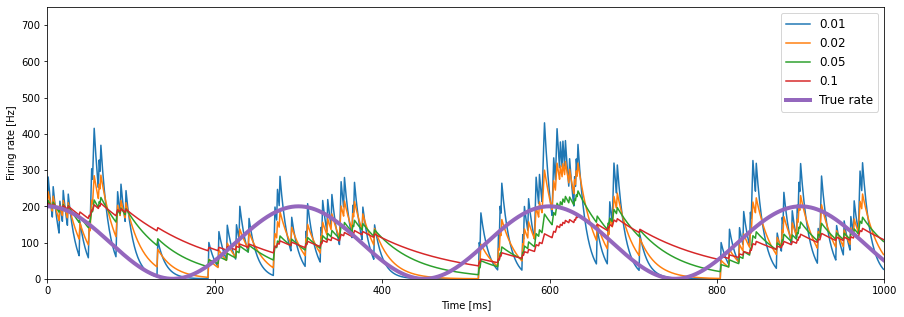

In [260]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(15, 5))

# Prep legend 
list1 = r_approx.columns
list2 = list1.to_list()
list2.append("True rate")

# Plot all the variables across time
plt.plot(r_approx[0:1000])
plt.plot(r_list[0:1000], linewidth=4)
ax.set_ylim([0, 750])
ax.set_xlim([0, 1000])
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Firing rate [Hz]")
plt.legend(list2, loc='upper right', fontsize=12)

In [261]:
# Determine the tau which best approximates the real firing rate by computing the the average 
# squared error of the estimate

square_error = pd.DataFrame({
    '0.01': [],
    '0.02': [],
    '0.05': [],
    '0.1': []
})

for count, r in enumerate(r_list): 
    for tau in tau_approx_list: 
        square_error.loc[count, str(tau)] = (r_approx.loc[count, str(tau)] - r)**2

In [262]:
print(f"The value of tau which best approxiamtes the real firing rate is {square_error.sum().idxmin()} ms")

The value of tau which best approxiamtes the real firing rate is 0.02 ms


# Part 5
For a constant rate Poisson process, every specific (up to a finite resolution) sequence of N spikes occurring over a given time interval is equally likely. This seems paradoxical because we certainly do not expect to see all N spikes appearing within the first 1% of the time interval. Resolve this paradox.

Firstly, the constant-rate Poisson process (aka homogeneous) means the rate at which spikes are generated throughout the time interval (trial duration) remains the same; it also qualifes as i.i.d.. Secondly, while we do not expect to see all N spikes appearing during the first 1 % of the time interval, it is a $\textit{possible}$ but $\textit{unlikely}$ since we would be drawing the ISIs from the initial (left) part of the distribution. 

The drawing from the ISI distribution for each two successive spikes in the homogeneous Poisson process is UNRELATED to the number of spikes that has just occurred. This is the memorylessness property of the Poisson process. 

The memorylessness property in this case is the fact that the probability of an event occurring at any given time interval is independent of how much time has already elapsed since the start. 

It is the same idea as flipping a coin 50 times and getting 50 heads in a row. The fact that the next coin flip is a head even though the previous one was a head as well is irrelevant to the coin since it has no memory of its previous flips. In Basketball, this is called the "hot hand fallacy".

To be more mathematically rigorous, taking a closer look at the Poisson distribution 

$$
P(k) = (\lambda T)^k \cdot \frac{e^{-\lambda T}}{ k!}
$$

Where $T$ is the time interval and $\lambda$ is the rate. If we consider a number of spikes N which occurred during the whole interval, it is interesting to consider the probability of observing any particular sequence of N spikes. This can be obtained by simply multiplying the probabilities of each individual spike occurrence, since the events are independent. The probability of a specific sequence of N spikes is then define as:

$$
P(sequence) = \lambda^N \cdot \frac{e^{-\lambda T}}{ N!}
$$

Which is actually just the formula for the Poisson point process. Mathematically, the memoryless property can be inferred from the equation above since it does not depend on any expresson quantifying the amount of elapsed time. Therefore, all possible sequences of N spikes are equally likely since they all have the same probability. 

# Part 6
Build an approximatewhite-noise stimulus by choosing random values at discrete times separated by a time-step interval $\Delta t$. Plot its autocorrelation function and power spectrum (use the matlab® function spectrum or psd). Discuss how well this stimulus matches an ideal white-noise stimulus given the value of $\Delta t$ you used.

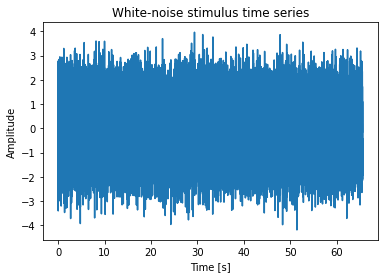

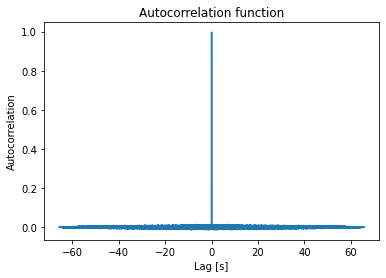

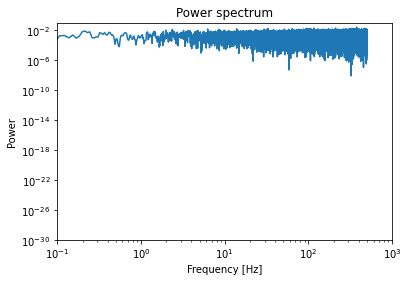

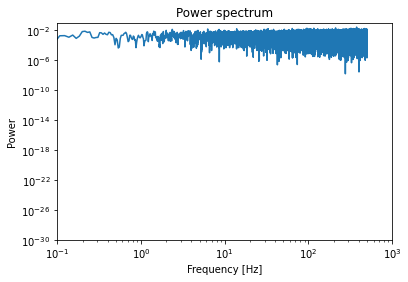

In [4]:
# Parameters
n_samples = 2**16   # number of samples, about 8000. The reason for this is to make the psd faster 
dt = 0.001          # time step in secons, 1 ms 

# Generate white-noise stimulus by sampling from a normal distribution with zero mean and SD of 1 
stimulus = np.random.randn(n_samples)

# Return evenly spaced values from 0 to 10000 and multiply by the dt
t = np.arange(n_samples) * dt

plt.plot(t, stimulus)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('White-noise stimulus time series')

# Compute autocorrelation function, peak at 0 wherein the value is the variance of the signal 
lags = np.arange(-n_samples+1, n_samples)*dt 
acf = np.correlate(stimulus, stimulus, mode='full')/n_samples
plt.figure()
plt.plot(lags, acf)
plt.xlabel('Lag [s]')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation function')

# Compute power spectrum
# Here I show two different approaches, one is the scipy.signal module and the other is using the plt module. 
# The first one is far more user friendly and it makes several correct assumptions a priori! It was surprisingly
# challenging to get the two to produce almost exactly the same figure and I think it's still not 100 % identical

freq1, Pxx1 = scipy.signal.periodogram(stimulus, fs=1/dt, nfft=n_samples, window="hamming")
plt.figure()
plt.loglog(freq1, Pxx1)
plt.ylim(10**-30, 10**-1)
plt.xlim(10**-1, 10**3)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.title('Power spectrum')

plt.figure()
Pxx2, freq2 = plt.psd(stimulus, Fs=1/dt, NFFT=n_samples)
plt.close()
plt.figure()
plt.loglog(freq2, Pxx2)
plt.ylim(10**-30, 10**-1)
plt.xlim(10**-1, 10**3)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.title('Power spectrum')
plt.show()

In [264]:
print(f"The autocorrelation function of white noise should be approximately (ideally) "+
      f"0 everywhere except at time lag of 0 where its value is equal to the variance of "+ 
      f"the data. Indeed, the variance of the original signal is {np.var(stimulus):.3f} "+
      f"and the value at 0 time lag is {acf[int(np.ceil(len(acf)/2)-1)]:.3f}")

The autocorrelation function of white noise should be approximately (ideally) 0 everywhere except at time lag of 0 where its value is equal to the variance of the data. Indeed, the variance of the original signal is 1.004 and the value at 0 time lag is 1.004


In idealised white noise the autocorrelation is precisely equal to the variance at lag of 0 and it is 0 at all other values (parametrised by the delta function). Similarly, its value in the power spectral density (PSD) plot is equal to 

$$
\frac{Variance}{FS / 2}
$$

Which in our case is approximately $ \frac{1}{0.01/2} $ or $2 \cdot 10^{-3}$. Both of these are approximately what we have which is excellent news for our white-noise-like stimulus. 

# Part 7
Consider a model with a firing rate determined in terms of a stimulus $s(t)$ by integrating the equation

$$
\tau_r\frac{d r_{est}(t)}{dt} = [r_0 +s]_+ -r_{est}(t)
$$

where $r_0$ is a constant that determines the background firing rate and $\tau_r = 20$ ms. Drive the model with an approximate white-noise stimulus. Adjust the amplitude of the white-noise and the parameter $r_0$ so that rectification is not a big effect (i.e. $r_0 +s > 0$ most of the time). From the responses of the model, compute the stimulus-response correlation function, $Q_{rs}$. Next, generate spikes from this model using a Poisson generator with a rate $r_{est}(t)$, and compute the spike-triggered average stimulus from the spike trains produced by the white-noise stimulus. By comparing the stimulus-response correlation function with the spike-triggered average, verify that equation 1.22 is satisfied. Examine what happens if you set $r_0 = 0$, so that the white-noise stimulus becomes half-wave rectified.

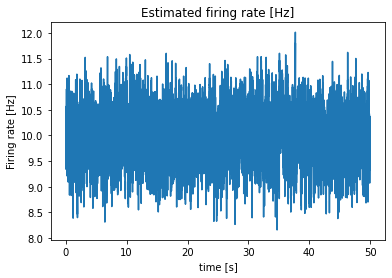

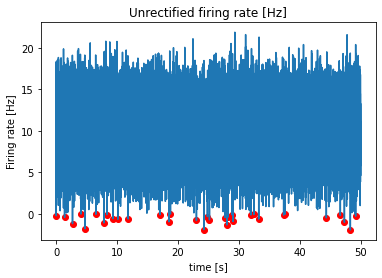

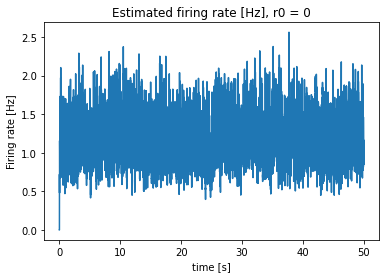

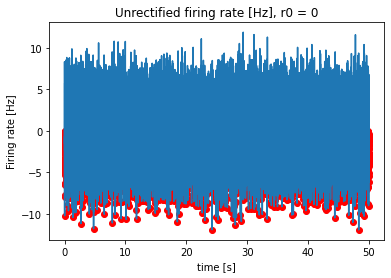

In [118]:
# First, let's set all of the variables 
tau_r = 0.02
r_0 = 10 # Background firing rate 
r_0_alt = 0 # For the last part of the exercise 
dt = 0.001 # 1 ms 
max_T = 50 # s
time_vector = np.arange(0, max_T, dt)
WN_amp = 3

# Create lists 
r_est = []
r_est_alt = []
spikes_wn = []
spikes_wn_alt = []
rect_FR = []
rect_FR_alt = []
unrectified_FR = []
unrectified_FR_alt = []

# Append the background firing rate to the list of estimated firing rates at each time point, 
# i.e., make it the initial value
# r_est.append(r_0)

# Iterate over all time points in the time vector 
for j, t in enumerate(time_vector):
    
    # We need to perform the rectification, we can use an if statement to that end. Make it into a 
    # list so we can check that the amplitdue for white noise is appropriate
    rect_FR.append(r_0 + WN_amp*stimulus[j])
    rect_FR_alt.append(r_0_alt + WN_amp*stimulus[j])
    unrectified_FR.append(r_0 + WN_amp*stimulus[j])
    unrectified_FR_alt.append(r_0_alt + WN_amp*stimulus[j])
    
    # Rectify 
    if rect_FR[j] < 0:
        rect_FR[j] = 0 
        
    if rect_FR_alt[j] < 0:
        rect_FR_alt[j] = 0 
    
    if j == 0: 
        
        # Calculate the instantaneous change in FR 
        d_r_est = (rect_FR[j] - r_0)*dt/tau_r
        d_r_est_alt = (rect_FR_alt[j] - r_0_alt)*dt/tau_r
        
        # Sum it with the FR from previous trial and add it to the list
        r_est.append(r_0 + d_r_est)
        
        # In the alternative case the r_0_alt is 0 so we could dispense with it but I kept it for consistency 
        r_est_alt.append(r_0_alt + d_r_est_alt)
    
    else: 
        
        # Calculate the instantaneous change in FR 
        d_r_est = (rect_FR[j] - r_est[j-1])*dt/tau_r
        d_r_est_alt = (rect_FR_alt[j] - r_est_alt[j-1])*dt/tau_r
    
        # Sum it with the FR from previous trial and add it to the list
        r_est.append(r_est[j-1]+d_r_est)
        r_est_alt.append(r_est_alt[j-1]+d_r_est_alt)
    
    
    # Generate spikes using a Poisson generator for the second part of the question 
    spikes_wn.append(int(np.random.poisson(lam=r_est[j]*dt, size=1)))
    spikes_wn_alt.append(int(np.random.poisson(lam=r_est_alt[j]*dt, size=1)))

# Ensure only one spike    
spikes_wn = np.array(spikes_wn)
spikes_wn[spikes_wn > 1] = 1
spikes_wn_alt = np.array(spikes_wn_alt)
spikes_wn_alt[spikes_wn_alt > 1] = 1

# Plot the firing rate 
plt.plot(time_vector, r_est)
plt.xlabel('time [s]')
plt.ylabel('Firing rate [Hz]')
plt.title('Estimated firing rate [Hz]')

# Now plot the unrectified firing rate to make sure our rectification does not change too much. In red are point
# which were rectified to 0, clearly only a handful so we can rest assured about the WN coefficient 
plt.figure()
plt.plot(time_vector, unrectified_FR)
plt.scatter(pd.Series(time_vector).loc[pd.Series(unrectified_FR)<0], pd.Series(unrectified_FR).loc[pd.Series(unrectified_FR)<0], color='r')
plt.xlabel('time [s]')
plt.ylabel('Firing rate [Hz]')
plt.title('Unrectified firing rate [Hz]')

# Plot the same graphs in the alternative scenario
plt.figure()
plt.plot(time_vector, r_est_alt)
plt.xlabel('time [s]')
plt.ylabel('Firing rate [Hz]')
plt.title('Estimated firing rate [Hz], r0 = 0')

plt.figure()
plt.plot(time_vector, unrectified_FR_alt)
plt.scatter(pd.Series(time_vector).loc[pd.Series(unrectified_FR_alt)<0], pd.Series(unrectified_FR_alt).loc[pd.Series(unrectified_FR_alt)<0], color='r')
plt.xlabel('time [s]')
plt.ylabel('Firing rate [Hz]')
plt.title('Unrectified firing rate [Hz], r0 = 0')
plt.show()

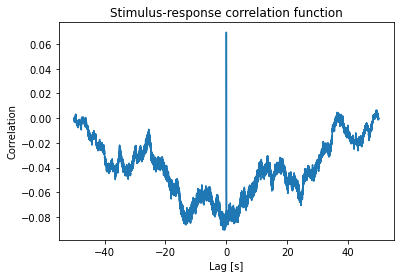

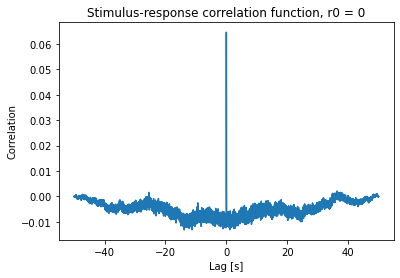

In [119]:
# Obtain the correlation function 
lags_RS = np.arange(-len(r_est)+1, len(r_est))*dt 
Q_RS = scipy.signal.correlate(r_est, stimulus[0: len(r_est)], mode='full')/len(r_est)
Q_RS_alt = scipy.signal.correlate(r_est_alt, stimulus[0: len(r_est)], mode='full')/len(r_est)

# Plot the stimulus correlation function
plt.figure()
plt.plot(lags_RS, Q_RS)
plt.xlabel('Lag [s]')
plt.ylabel('Correlation')
plt.title('Stimulus-response correlation function')

plt.figure()
plt.plot(lags_RS, Q_RS_alt)
plt.xlabel('Lag [s]')
plt.ylabel('Correlation')
plt.title('Stimulus-response correlation function, r0 = 0')
plt.show()

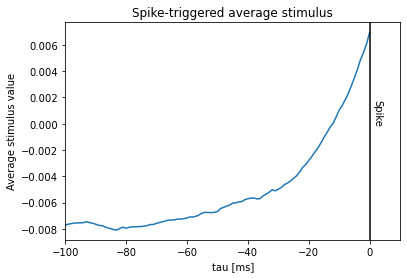

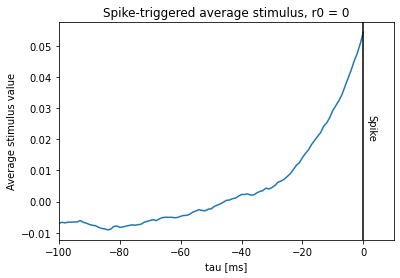

In [125]:
# Compute the spike-triggered average stimulus (STA) from the spike trains produced by the white-noise stimulus
STA = np.flip(Q_RS)*(1/np.mean(r_est))
STA_alt = np.flip(Q_RS_alt)*(1/np.mean(r_est_alt))

# Plot the STA 
plt.figure()
plt.plot(1000*lags_RS[round(len(lags_RS)/2)-101:round(len(lags_RS)/2)], STA[round(len(lags_RS)/2)-101:round(len(lags_RS)/2)])
plt.axvline(color='k') 
plt.text(1,0,'Spike',rotation=270)
plt.xlabel('tau [ms]')
plt.xlim(-100, 10)
plt.ylabel('Average stimulus value')
plt.title('Spike-triggered average stimulus')
plt.show()

# Plot the alternative STA 
plt.figure()
plt.plot(1000*lags_RS[round(len(lags_RS)/2)-101:round(len(lags_RS)/2)], STA_alt[round(len(lags_RS)/2)-101:round(len(lags_RS)/2)])
plt.axvline(color='k') 
plt.text(1,0.02,'Spike',rotation=270)
plt.xlabel('tau [ms]')
plt.xlim(-100, 10)
plt.ylabel('Average stimulus value')
plt.title('Spike-triggered average stimulus, r0 = 0')
plt.show()

In [123]:
print(f"In the first STA graph, we can see that the typical stimulus was the highest in amplitude right before a spike was generated. This is sensible since we are driving the estimated firing rate, which consequently drives the Poisson spike generator, with the white noise stimulus. On the other hand, if we turn the background firing rate to 0, then the stimulus must be far larger (an order of magnitude in this case) to trigger a spike, on average.")

In the first STA graph, we can see that the typical stimulus was the highest in amplitude right before a spike was generated. This is sensible since we are driving the estimated firing rate, which consequently drives the Poisson spike generator, with the white noise stimulus. On the other hand, if we turn the background firing rate to 0, then the stimulus must be far larger (an order of magnitude in this case) to trigger a spike, on average.


# Part 8
matlab® file c1p8.mat contains data collected and provided by Rob de Ruyter van Steveninck from a fly H1 neuron responding to an approximate white-noise visual motion stimulus. Data were collected for 20 minutes at a sampling rate of 500 Hz. In the file, rho is a vector that gives the sequence of spiking events or nonevents at the sampled times (every 2 ms). When an element of rho is one, this indicates the presence of a spike at the corresponding time, whereas a zero value indicates no spike. The variable stim gives the sequence of stimulus values at the sampled times. Calculate and plot the spike-triggered average from these data over the range from 0 to 300 ms (150 time steps). (Based on a problem from Sebastian Seung.)

In [239]:
# I compiled the data into a simple csv file wherein the first column is the stim and the second column is 
# the rho and the rows represent different observations

P8_data = pd.read_csv("C1P8.csv", header=None)

# Rename the columns for clarity 
P8_data.rename(columns={0: "Rho", 1: "Stim"}, inplace=True)

# Preview
P8_data.head()

,Rho,Stim
0,0,-111.948242
1,0,-81.806641
2,0,10.219727
3,0,83.364258
4,0,69.375000


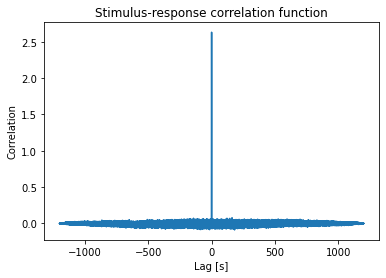

In [240]:
# To obtain the STA, we once again need the auto-correlation function
dt_H1 = 0.002

lags_H1 = np.arange(-len(P8_data.Stim)+1, len(P8_data.Stim))*dt_H1 
Q_RS_H1 = scipy.signal.correlate(P8_data.Rho, P8_data.Stim, mode='full')/len(P8_data.Stim)

# Plot the Q_RS just to check we are proceeding correctly 
plt.figure()
plt.plot(lags_H1, Q_RS_H1)
plt.xlabel('Lag [s]')
plt.ylabel('Correlation')
plt.title('Stimulus-response correlation function')
plt.show()

In [71]:
# Get the STA 
STA_H1 = np.flip(Q_RS_H1)*(1/np.mean(P8_data.Rho))

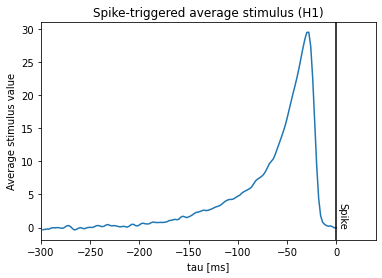

In [73]:
# Plot the range between 0 and 300 ms lag using 150 time points

plt.figure()
plt.plot(1000*lags_H1[round(len(lags_H1)/2)-150:round(len(lags_H1)/2)], STA_H1[round(len(lags_H1)/2)-150:round(len(lags_H1)/2)])
plt.axvline(color='k') 
plt.text(1,0,'Spike',rotation=270)
plt.xlabel('tau [ms]')
plt.xlim(-300, 40)
plt.ylabel('Average stimulus value')
plt.title('Spike-triggered average stimulus (H1)')
plt.show()

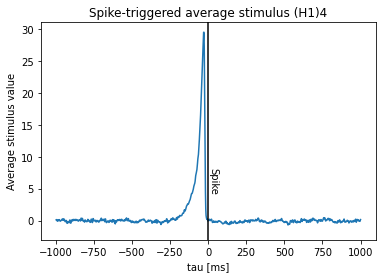

In [188]:
# Let's also see it in context to truly apprciate how well this works

plt.figure()
plt.plot(1000*lags_H1[round(len(lags_H1)/2)-500:round(len(lags_H1)/2)+500], STA_H1[round(len(lags_H1)/2)-500:round(len(lags_H1)/2)+500])
plt.axvline(color='k') 
plt.text(1, 4.5, 'Spike', rotation=270)
plt.xlabel('tau [ms]')
plt.ylim(-3, 31)
plt.ylabel('Average stimulus value')
plt.title('Spike-triggered average stimulus (H1)')
plt.show()

# Part 9
Using the data of problem 8, calculate and plot stimulus averages triggered on events consisting of a pair of spikes (which need not necessarily be adjacent) separated by a given interval (as in figure 1.10). Plot these two-spike-triggered average stimuli for various separation intervals ranging from 2 to 100 ms. (Hint: in matlab® , use convolution for pattern matching: e.g. find(conv(rho, [1 0 1])==2) will contain the indices of all the events with two spikes separated by 4 ms.) Plot, as a function of the separation between the two spikes, the magnitude of the difference between the two-spike-triggered average and the sum of two single-spike triggered averages (obtained in exercise 8) separated by the same time interval. At what temporal separation does this difference become negligibly small. (Based on a problem from Sebastian Seung.)

In [243]:
# First of all, create a list of intervals in ms, starting with 2 ms, as in there are no 0s between the spikes
separation_list = [2, 4, 10, 60, 80, 100]

# Make it into a dictionary 
sep_dict = {key: None for key in separation_list}
# lags_dict = {key: None for key in separation_list}
Q_RS_dict = {key: None for key in separation_list}
STA_H1_dict = {key: None for key in separation_list}

for value in separation_list: 
    sep_dict[value] = [0] * int(value/2-1)
    sep_dict[value].append(1)
    sep_dict[value].insert(0, 1)

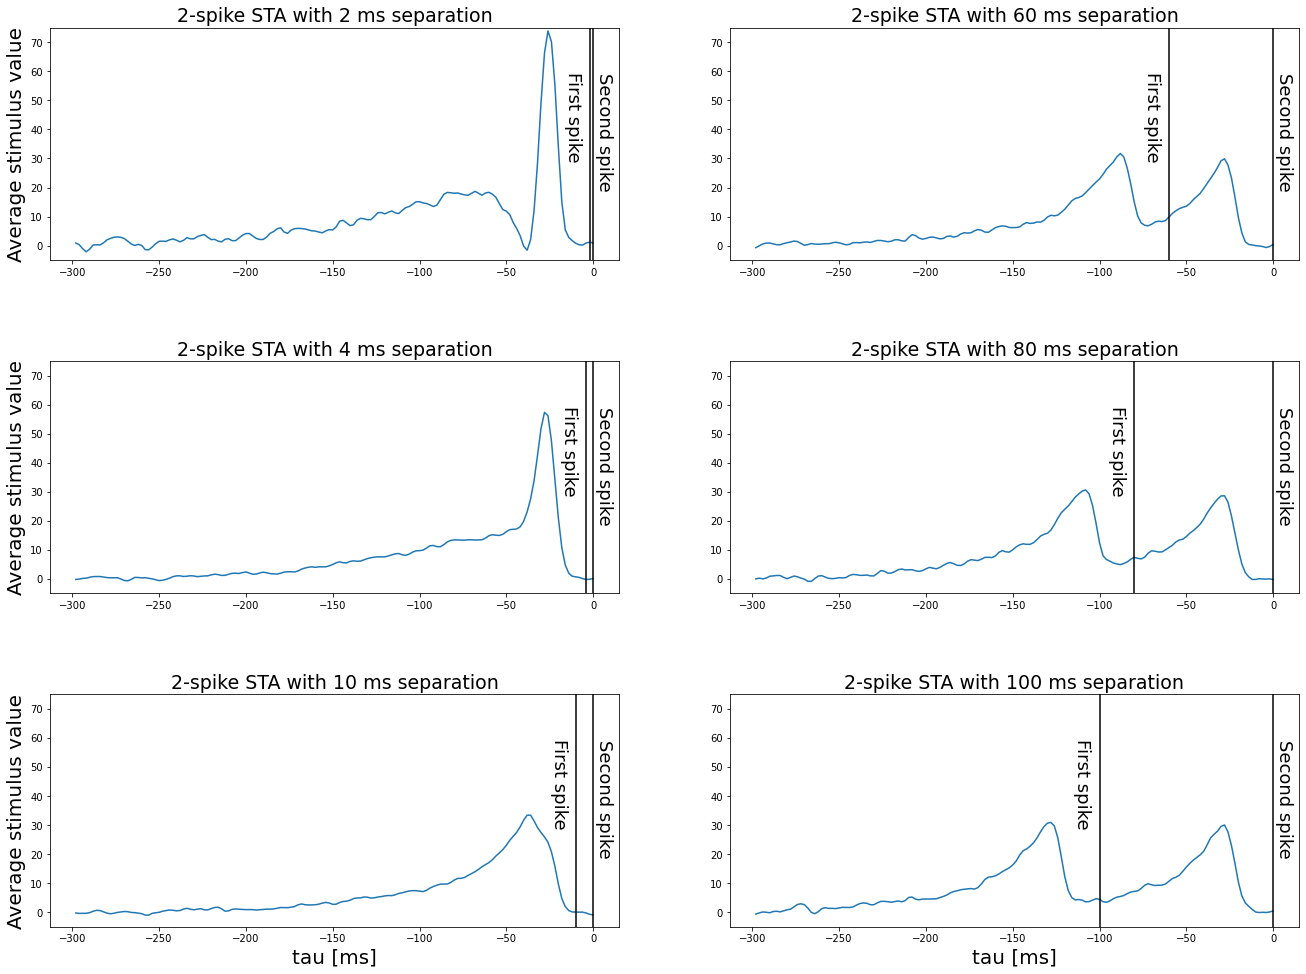

In [281]:
zero_data = [0] * len(P8_data.Stim)
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
plt.tight_layout(pad=8)
spike_y_list = [0.021, 0.15, 0.025]

# Loop over the dictionary 
for count, sep_val in enumerate(sep_dict):

    # Since we are doing the exercise in Python, we have to change the code. Numpy has a convolve function 
    # essentially identical to the MATLAB one and instead of 'find' we use 'where'
    conv_result = np.convolve(P8_data.Rho, sep_dict[sep_val])
    indices = np.where(conv_result == 2)[0]
    zero_data2 = [1 if i in indices else val for i, val in enumerate(zero_data)]
    Q_RS_dict[sep_val] = scipy.signal.correlate(zero_data2, P8_data.Stim, mode='full')/len(P8_data.Rho)
    STA_H1_dict[sep_val] = np.flip(Q_RS_dict[sep_val])*(1/np.mean(zero_data2))
    
    if count <= 2:
        axs[count, 0].plot(1000*lags_H1[round(len(lags_H1)/2)-150:round(len(lags_H1)/2)], STA_H1_dict[sep_val][round(len(lags_H1)/2)-150:round(len(lags_H1)/2)])
        axs[count, 0].axvline(color='k') 
        axs[count, 0].axvline(color='k', x=-sep_val) 
        axs[count, 0].text(-15-sep_val, 30, 'First spike', rotation=270, fontsize=18)
        axs[count, 0].text(1, 20, 'Second spike', rotation=270, fontsize=18)
        axs[count, 0].set_title(f"2-spike STA with {sep_val} ms separation", fontsize=19)
        axs[count, 0].set_ylim(-5, 75)

    else:
        axs[count-3, 1].plot(1000*lags_H1[round(len(lags_H1)/2)-150:round(len(lags_H1)/2)], STA_H1_dict[sep_val][round(len(lags_H1)/2)-150:round(len(lags_H1)/2)])
        axs[count-3, 1].axvline(color='k') 
        axs[count-3, 1].axvline(color='k', x=-sep_val) 
        axs[count-3, 1].text(-15-sep_val, 30, 'First spike', rotation=270, fontsize=18)
        axs[count-3, 1].text(1, 20, 'Second spike', rotation=270, fontsize=18)
        axs[count-3, 1].set_title(f"2-spike STA with {sep_val} ms separation", fontsize=19)
        axs[count-3, 1].set_ylim(-5, 75)

    axs[2, 0].set_xlabel('tau [ms]', fontsize=20)
    axs[2, 1].set_xlabel('tau [ms]', fontsize=20)
    axs[0, 0].set_ylabel('Average stimulus value', fontsize=20)
    axs[1, 0].set_ylabel('Average stimulus value', fontsize=20)
    axs[2, 0].set_ylabel('Average stimulus value', fontsize=20)

plt.show()

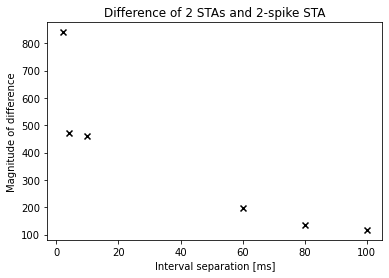

In [530]:
# Calculate the magnitude of the difference between the two-spike-triggered average and the sum of 
# two single-spike triggered averages (obtained in exercise 8) separated by the same time interval 

mag_of_diff = []
plt.figure()

# Loop over the intervals separating the spikes 
for sep_val in list(STA_H1_dict.keys()):
    
    # Firstly, we need to sum the STAs separated by a given interval (not a very elegant solution... )

    # Insert a padding of zeros to offset the STA
    plch2 = np.append(STA_H1, [0]*int(sep_val/2-1))
    
    # Remove the redundant values 
    plch2 = list(plch2)
    del plch2[0:int(sep_val/2-1)]
    
    # Sum the two
    two_STA = plch2 + STA_H1

    # Calculate the magnitude of difference (using the absolute value) across the range we've been working on
    mag_of_diff.append(np.abs(STA_H1_dict[sep_val][round(len(lags_H1)/2)-150:round(len(lags_H1)/2)] - 
                        two_STA[round(len(lags_H1)/2)-150:round(len(lags_H1)/2)]).sum())

    # Plot, as a function of the separation between the two spikes
    plt.scatter(sep_val, mag_of_diff[-1], c='k', marker='x')

plt.xlabel('Interval separation [ms]')
plt.ylabel('Magnitude of difference')
plt.title('Difference of 2 STAs and 2-spike STA')
plt.show()

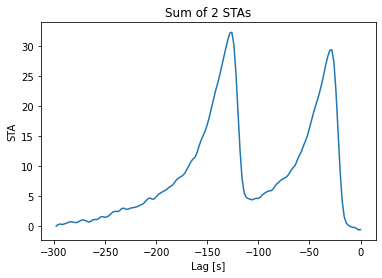

In [521]:
# Just to check we are doing things correctly, plot the sum of the two STAs with 100 ms separation
plt.figure()
plt.plot(1000*lags_H1[round(len(lags_H1)/2)-150:round(len(lags_H1)/2)], two_STA[round(len(lags_H1)/2)-150:round(len(lags_H1)/2)])
plt.xlabel('Lag [s]')
plt.ylabel('STA')
plt.title('Sum of 2 STAs')
plt.show()